# CommandMap Gamification Analysis : The "No Game" Pilot



In [52]:
import os 
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt

from util.survey_structure import MOTIVATION_8_PART_COLUMNS, MOTIVATION_8_PART_STATEMENTS


# MY_DATA_PATH = "./data/noGuide_revised.db"
# FOLDER_NAME = "no-guide-second-iteration"

SPOTLIGHT_DATA_PATH = "./data/game-training-pilot2.db"
NOGUIDE_DATA_PATH = "./data/noGuide-revised-questionnaire.db"
FOLDER_NAME = "spotlight-and-noguide-comparison"

# Note: this will all be reassigned to actual datasets below 
TRIAL_TABLE_NAME = "table_trialLog"
DEMOGRAPHICS = "questionnaire_demographics"
MOTIVATION_SHORT_ONE_NOGUIDE = "questionnaire_motivation_short_1"
MOTIVATION_SHORT_TWO_NOGUIDE = "questionnaire_motivation_short_2"
MOTIVATION_SHORT_THREE_NOGUIDE = "questionnaire_motivation_short_3"
MOTIVATION_SHORT_FOUR_NOGUIDE = "questionnaire_motivation_short_4"
MOTIVATION_SHORT_FIVE_NOGUIDE = "questionnaire_motivation_short_5"
MOTIVATION_SHORT_SIX_NOGUIDE = "questionnaire_motivation_short_6"
MOTIVATION_SHORT_SEVEN_NOGUIDE = "questionnaire_motivation_short_7"
MOTIVATION_SHORT_EIGHT_NOGUIDE = "questionnaire_motivation_short_8"
MOTIVATION_SHORT_NINE_NOGUIDE = "questionnaire_motivation_short_9"
MOTIVATION_SHORT_TEN_NOGUIDE = "questionnaire_motivation_short_10"
MOTIVATION_SHORT_ELEVEN_NOGUIDE = "questionnaire_motivation_short_11"
MOTIVATION_SHORT_TWELVE_NOGUIDE = "questionnaire_motivation_short_12"

MOTIVATION_SHORT_ONE = "questionnaire_motivation_short_1"
MOTIVATION_SHORT_TWO = "questionnaire_motivation_short_2"
MOTIVATION_SHORT_THREE = "questionnaire_motivation_short_3"
MOTIVATION_SHORT_FOUR = "questionnaire_motivation_short_4"
MOTIVATION_SHORT_FIVE = "questionnaire_motivation_short_5"
MOTIVATION_SHORT_SIX = "questionnaire_motivation_short_6"
MOTIVATION_SHORT_SEVEN = "questionnaire_motivation_short_7"
MOTIVATION_SHORT_EIGHT = "questionnaire_motivation_short_8"
MOTIVATION_SHORT_NINE = "questionnaire_motivation_short_9"
MOTIVATION_SHORT_TEN = "questionnaire_motivation_short_10"
MOTIVATION_SHORT_ELEVEN = "questionnaire_motivation_short_11"
MOTIVATION_SHORT_TWELVE = "questionnaire_motivation_short_12"

PARTICIPANT = "participant"
PROGRESS = "progress"


## Read in the data

In [53]:
spotlight_connection = sqlite3.connect(SPOTLIGHT_DATA_PATH)
cursor = spotlight_connection.cursor()

# reading all table names
table_list = [a for a in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

print("Your database contains the following tables:")
print(table_list)

SPOTLIGHT_TRIAL_DATA = pd.read_sql_query(f"SELECT *FROM {TRIAL_TABLE_NAME}", spotlight_connection)
SPOTLIGHT_DEMOGRAPHICS = pd.read_sql_query(f"SELECT * FROM {DEMOGRAPHICS}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_ONE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_ONE}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_TWO = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TWO}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_THREE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_THREE}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_FOUR = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_FOUR}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_FIVE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_FIVE}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_SIX = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_SIX}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_SEVEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_SEVEN}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_EIGHT = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_EIGHT}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_NINE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_NINE}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_TEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TEN}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_ELEVEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_ELEVEN}", spotlight_connection)
SPOTLIGHT_MOTIVATION_SHORT_TWELVE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TWELVE}", spotlight_connection)
SPOTLIGHT_PARTICIPANT = pd.read_sql_query(f"SELECT * FROM {PARTICIPANT}", spotlight_connection)
SPOTLIGHT_PROGRESS = pd.read_sql_query(f"SELECT * FROM {PROGRESS}", spotlight_connection)
spotlight_connection.close()

Your database contains the following tables:
[('participant',), ('progress',), ('radio_grid_log',), ('display',), ('session_store',), ('questionnaire_motivation_short_9',), ('questionnaire_motivation_short_7',), ('questionnaire_motivation_short_5',), ('questionnaire_preferences',), ('questionnaire_motivation_short_11',), ('questionnaire_prolific_start',), ('questionnaire_motivation_short_1',), ('questionnaire_motivation_short_8',), ('questionnaire_demographics',), ('questionnaire_motivation_short_4',), ('questionnaire_motivation_short_3',), ('questionnaire_motivation_short_12',), ('questionnaire_motivation_short_2',), ('questionnaire_motivation_short_10',), ('questionnaire_motivation_short_6',), ('table_trialLog',), ('table_streamLog',)]


In [54]:
noguide_connection = sqlite3.connect(NOGUIDE_DATA_PATH)
cursor = noguide_connection.cursor()

# reading all table names
table_list = [a for a in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

print("Your database contains the following tables:")
print(table_list)

NOGUIDE_TRIAL_DATA = pd.read_sql_query(f"SELECT *FROM {TRIAL_TABLE_NAME}", noguide_connection)
NOGUIDE_DEMOGRAPHICS = pd.read_sql_query(f"SELECT * FROM {DEMOGRAPHICS}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_ONE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_ONE_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_TWO = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TWO_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_THREE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_THREE_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_FOUR = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_FOUR_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_FIVE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_FIVE_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_SIX = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_SIX_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_SEVEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_SEVEN_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_EIGHT = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_EIGHT_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_NINE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_NINE_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_TEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TEN_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_ELEVEN = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_ELEVEN_NOGUIDE}", noguide_connection)
NOGUIDE_MOTIVATION_SHORT_TWELVE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_TWELVE_NOGUIDE}", noguide_connection)
NOGUIDE_PARTICIPANT = pd.read_sql_query(f"SELECT * FROM {PARTICIPANT}", noguide_connection)
NOGUIDE_PROGRESS = pd.read_sql_query(f"SELECT * FROM {PROGRESS}", noguide_connection)
noguide_connection.close()

Your database contains the following tables:
[('participant',), ('progress',), ('radio_grid_log',), ('display',), ('session_store',), ('questionnaire_motivation_short_9',), ('questionnaire_motivation_short_7',), ('questionnaire_motivation',), ('questionnaire_motivation_short_5',), ('questionnaire_preferences',), ('questionnaire_motivation_short_11',), ('questionnaire_prolific_start',), ('questionnaire_motivation_questionnaire_revised',), ('questionnaire_motivation_short_1',), ('questionnaire_motivation_short_8',), ('questionnaire_demographics',), ('questionnaire_motivation_short_4',), ('questionnaire_motivation_short_3',), ('questionnaire_motivation_short_12',), ('questionnaire_motivation_short_2',), ('questionnaire_motivation_short_10',), ('questionnaire_motivation_short_6',), ('table_trialLog',), ('table_streamLog',)]


In [55]:
SPOTLIGHT_MOTIVATION_SHORT_ONE['block'] = 1
SPOTLIGHT_MOTIVATION_SHORT_TWO['block'] = 2
SPOTLIGHT_MOTIVATION_SHORT_THREE['block'] = 3
SPOTLIGHT_MOTIVATION_SHORT_FOUR['block'] = 4
SPOTLIGHT_MOTIVATION_SHORT_FIVE['block'] = 5
SPOTLIGHT_MOTIVATION_SHORT_SIX['block'] = 6
SPOTLIGHT_MOTIVATION_SHORT_SEVEN['block'] = 7
SPOTLIGHT_MOTIVATION_SHORT_EIGHT['block'] = 8
SPOTLIGHT_MOTIVATION_SHORT_NINE['block'] = 9
SPOTLIGHT_MOTIVATION_SHORT_TEN['block'] = 10
SPOTLIGHT_MOTIVATION_SHORT_ELEVEN['block'] = 11
SPOTLIGHT_MOTIVATION_SHORT_TWELVE['block'] = 12

SPOTLIGHT_IMI = pd.concat([SPOTLIGHT_MOTIVATION_SHORT_ONE, SPOTLIGHT_MOTIVATION_SHORT_TWO, SPOTLIGHT_MOTIVATION_SHORT_THREE, SPOTLIGHT_MOTIVATION_SHORT_FOUR,
                 SPOTLIGHT_MOTIVATION_SHORT_FIVE, SPOTLIGHT_MOTIVATION_SHORT_SIX, SPOTLIGHT_MOTIVATION_SHORT_SEVEN, SPOTLIGHT_MOTIVATION_SHORT_EIGHT,
                 SPOTLIGHT_MOTIVATION_SHORT_NINE, SPOTLIGHT_MOTIVATION_SHORT_TEN, SPOTLIGHT_MOTIVATION_SHORT_ELEVEN, SPOTLIGHT_MOTIVATION_SHORT_TWELVE], ignore_index=True)


In [56]:
NOGUIDE_MOTIVATION_SHORT_ONE['block'] = 1
NOGUIDE_MOTIVATION_SHORT_TWO['block'] = 2
NOGUIDE_MOTIVATION_SHORT_THREE['block'] = 3
NOGUIDE_MOTIVATION_SHORT_FOUR['block'] = 4
NOGUIDE_MOTIVATION_SHORT_FIVE['block'] = 5
NOGUIDE_MOTIVATION_SHORT_SIX['block'] = 6
NOGUIDE_MOTIVATION_SHORT_SEVEN['block'] = 7
NOGUIDE_MOTIVATION_SHORT_EIGHT['block'] = 8
NOGUIDE_MOTIVATION_SHORT_NINE['block'] = 9
NOGUIDE_MOTIVATION_SHORT_TEN['block'] = 10
NOGUIDE_MOTIVATION_SHORT_ELEVEN['block'] = 11
NOGUIDE_MOTIVATION_SHORT_TWELVE['block'] = 12

NOGUIDE_IMI = pd.concat([NOGUIDE_MOTIVATION_SHORT_ONE, NOGUIDE_MOTIVATION_SHORT_TWO, NOGUIDE_MOTIVATION_SHORT_THREE, NOGUIDE_MOTIVATION_SHORT_FOUR,
                 NOGUIDE_MOTIVATION_SHORT_FIVE, NOGUIDE_MOTIVATION_SHORT_SIX, NOGUIDE_MOTIVATION_SHORT_SEVEN, NOGUIDE_MOTIVATION_SHORT_EIGHT,
                 NOGUIDE_MOTIVATION_SHORT_NINE, NOGUIDE_MOTIVATION_SHORT_TEN, NOGUIDE_MOTIVATION_SHORT_ELEVEN, NOGUIDE_MOTIVATION_SHORT_TWELVE], ignore_index=True)


## Preprocessing

Of the participants who did not abandon the study, one participant timed out and another reported technical issues. There were additional records in the database generated from testing the study on the server. All of these are removed before analysis. 

After removing unusable data, there are 10 participants. 

In [57]:
# for first no guide iteration:
# IDs 1-3: Testing
# IDs 5, 8, 13: Technical issue, did not finish, timeout

NOGUIDE_IDS_TO_REMOVE = [1, 2]
SPOTLIGHT_IDS_TO_REMOVE = [1, 2]

SPOTLIGHT_TRIAL_DATA = SPOTLIGHT_TRIAL_DATA[~SPOTLIGHT_TRIAL_DATA["participantID"].isin(SPOTLIGHT_IDS_TO_REMOVE)]
SPOTLIGHT_DEMOGRAPHICS = SPOTLIGHT_DEMOGRAPHICS[~SPOTLIGHT_DEMOGRAPHICS["participantID"].isin(SPOTLIGHT_IDS_TO_REMOVE)]
SPOTLIGHT_IMI = SPOTLIGHT_IMI[~SPOTLIGHT_IMI["participantID"].isin(SPOTLIGHT_IDS_TO_REMOVE)]
SPOTLIGHT_PARTICIPANT = SPOTLIGHT_PARTICIPANT[~SPOTLIGHT_PARTICIPANT["participantID"].isin(SPOTLIGHT_IDS_TO_REMOVE)]

NOGUIDE_TRIAL_DATA = NOGUIDE_TRIAL_DATA[~NOGUIDE_TRIAL_DATA["participantID"].isin(NOGUIDE_IDS_TO_REMOVE)]
NOGUIDE_TRIAL_DATA = NOGUIDE_TRIAL_DATA[~NOGUIDE_TRIAL_DATA["participantID"].isin(NOGUIDE_IDS_TO_REMOVE)]
NOGUIDE_DEMOGRAPHICS = NOGUIDE_DEMOGRAPHICS[~NOGUIDE_DEMOGRAPHICS["participantID"].isin(NOGUIDE_IDS_TO_REMOVE)]
NOGUIDE_IMI = NOGUIDE_IMI[~NOGUIDE_IMI["participantID"].isin(NOGUIDE_IDS_TO_REMOVE)]
NOGUIDE_PARTICIPANT = NOGUIDE_PARTICIPANT[~NOGUIDE_PARTICIPANT["participantID"].isin(NOGUIDE_IDS_TO_REMOVE)]



## Demographic Data Overview


All participants were familiar with Micosoft applications and did not have colour vision deficiency. One participant reported that they did not have normal visual ability but declined to specify the nature of their visual disability. 

In [58]:
# DEMOGRAPHICS[["microsoftFamiliarity", "visionAbility", "CVD", "visionAblilityType"]]

The participants consisted of 8 women and 2 men. 

In [59]:


# sns.histplot(DEMOGRAPHICS["gender"])

Ages of participants ranged from 22 to 72.

In [60]:
# DEMOGRAPHICS['age'].max()
# DEMOGRAPHICS['age'].min()

# sns.histplot(DEMOGRAPHICS["age"])

In [61]:
# DEMOGRAPHICS["occupation"]

In [62]:
# sns.histplot(DEMOGRAPHICS['compUsage'])

In [63]:
# DEMOGRAPHICS['videoGameUsage']

In [64]:
# sns.histplot(DEMOGRAPHICS['videoGameUsage'])

## IMI Motivational Survey



In [65]:
# Note Side Effects: This function will alter the original dataframe (shallow copy)
def format_likert_data_for_histogram(df: pd.DataFrame, likert_columns: list) -> pd.DataFrame:
    for column_name in likert_columns:
        df[column_name] = df[column_name].replace('1 (Strongly Disagree)', '1')
        df[column_name] = df[column_name].replace('7 (Strongly Agree)', '7')
        df[column_name] = df[column_name].replace('4 (Neutral)', '4')
        df[column_name] = df[column_name].astype('int64')
    return df

In [66]:

SPOTLIGHT_IMI['condition'] = 'spotlight'
NOGUIDE_IMI['condition'] = 'no-guide'
IMI = pd.concat([SPOTLIGHT_IMI, NOGUIDE_IMI], ignore_index=True)
IMI.fillna(0, inplace=True)
IMI = format_likert_data_for_histogram(IMI, MOTIVATION_8_PART_COLUMNS)


if not os.path.exists(f"./plots/{FOLDER_NAME}/imi_overall/"):
    os.makedirs(f"./plots/{FOLDER_NAME}/imi_overall/")

for block in IMI['block'].unique():
    for likert_data in MOTIVATION_8_PART_COLUMNS:
        plt.figure()
        sns.histplot(data=IMI[IMI['block']==block], multiple='dodge', hue='condition', x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_8_PART_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
        plt.savefig(f"./plots/{FOLDER_NAME}/imi_overall/{likert_data}_block_{block}.png")
        plt.close()

### Combining All IMI Responses: Histograms

The below was meant for single datasets.

In [67]:
# if not os.path.exists(f"./plots/{FOLDER_NAME}/imi_all_surveys_histograms/"):
#     os.makedirs(f"./plots/{FOLDER_NAME}/imi_all_surveys_histograms/")

# sns.set_theme()
# for likert_data in MOTIVATION_SHORT_LIKERT_COLUMNS:
#     plt.figure()
#     sns.histplot(data=IMI, hue='block', multiple='dodge', x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
#     plt.savefig(f"./plots/{FOLDER_NAME}/imi_all_surveys_histograms/{likert_data}.png")
#     plt.close()

### Mean Response Per Statement Per Survey

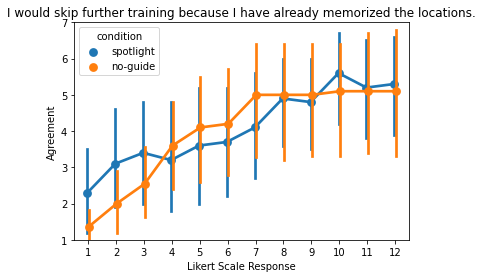

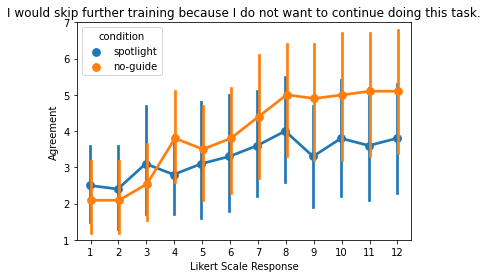

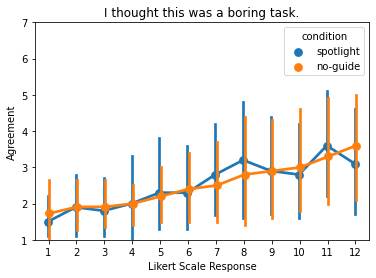

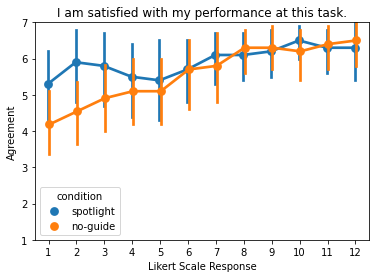

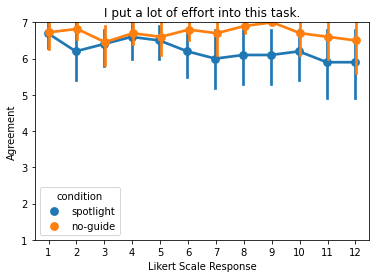

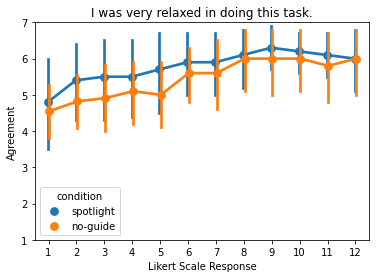

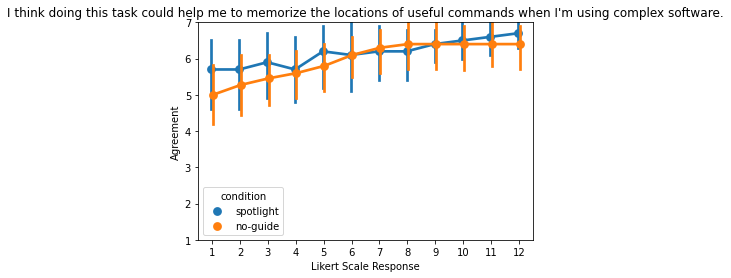

In [68]:

if not os.path.exists(f"./plots/{FOLDER_NAME}/imi_all_surveys_pointplots/"):
    os.makedirs(f"./plots/{FOLDER_NAME}/imi_all_surveys_pointplots/")

for likert_data in MOTIVATION_8_PART_COLUMNS:
    plt.figure()
    plt.ylim(1, 7)
    sns.pointplot(data=IMI, x='block', y=likert_data, hue='condition', dodge=True, errorbar=('ci', 95)).set(title=MOTIVATION_8_PART_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Agreement")
    plt.savefig(f"./plots/{FOLDER_NAME}/imi_all_surveys_pointplots/{likert_data}.png")

# IMI Scoring

Note that the standard IMI also measures Perceived Choice, however these "choice" questions were awkward in our survey and were excluded. 

In [69]:
REVERSE_SCORED_COLUMNS = ['boring_task', 'relaxed_task']

for col in REVERSE_SCORED_COLUMNS:
    IMI[col] = 8 - IMI[col]
    

In [70]:

# IMI_GUIDE = {
#     "Interest/Enjoyment": ['boring_task', 'enjoyable_task'],
#     "Perceived_Competence": ['satisfied_performance','couldnt_do_well'],
#     "Effort/Importance": ['effort_task', 'didnt_try_hard'],
#     "Tension/Pressure": ['felt_tense', 'relaxed_task'],
#     "Value/Usefulness": ['help_memorize_commands'],
#     # "Compliance": ['skip_remaining_training']
#     "Compliance": ['engagement']
# }

IMI_8_PART_GUIDE = {
    "Compliance-Targets_Memorized": ['already_memorized'],
    "Compliance-Nonengagement": ['dont_want_to_continue'],
    "Interest/Enjoyment": ['boring_task'],
    "Perceived_Competence": ['satisfied_performance'],
    "Effort/Importance": ['effort_task'],
    "Tension/Pressure": ['relaxed_task'],
    "Value/Usefulness": ['help_memorize_commands'],
}

In [71]:
for imi_category, imi_columns in IMI_8_PART_GUIDE.items():
    category_name:str = f'participant_{imi_category.lower().replace("/", "_")}'
    IMI[category_name] = 0
    for block in IMI['block'].unique():
        mean_participant_imi = IMI[IMI['block']==block][imi_columns].mean(axis=1)
        IMI.loc[(IMI['block']==block), [category_name]] = mean_participant_imi


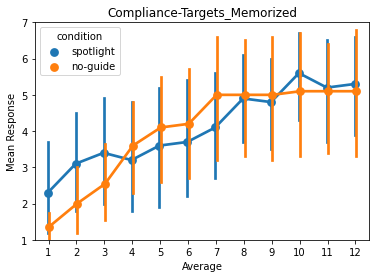

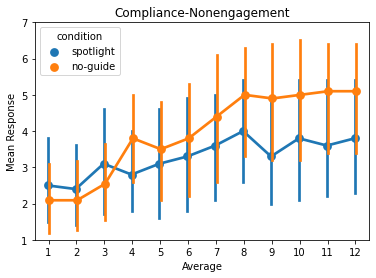

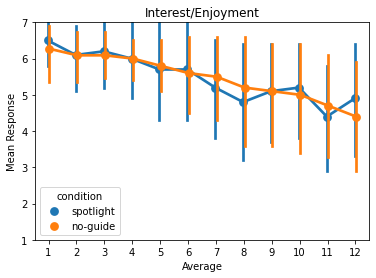

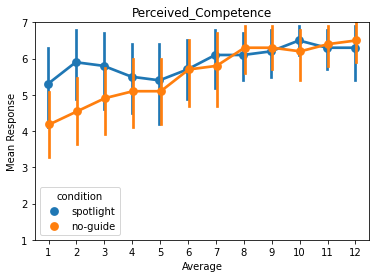

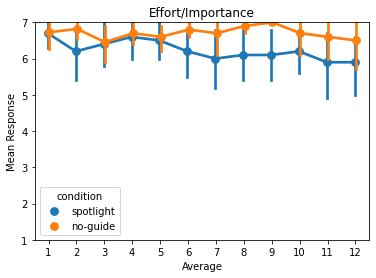

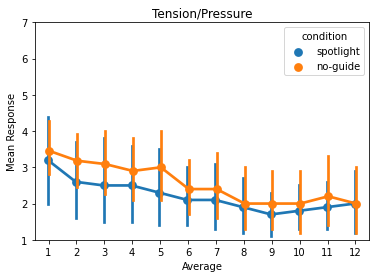

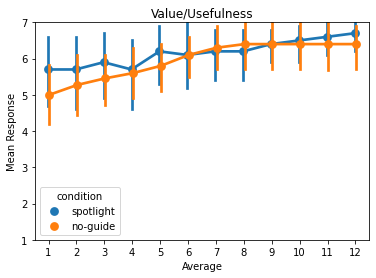

In [72]:
if not os.path.exists(f"./plots/{FOLDER_NAME}/imi_categories_pointplots/"):
    os.makedirs(f"./plots/{FOLDER_NAME}/imi_categories_pointplots/")

for imi_category in IMI_8_PART_GUIDE.keys():
    plt.figure()
    sns.pointplot(data=IMI , x='block', hue='condition', y=f'participant_{imi_category.lower().replace("/", "_")}', dodge=True, errorbar=('ci', 95)).set(title=imi_category, xlabel="Average", ylabel="Mean Response")
    plt.ylim(1, 7)
    plt.savefig(f"./plots/{FOLDER_NAME}/imi_categories_pointplots/{imi_category.replace('/', '_')}.png")
    

# Trial Log Data

## Time to complete trial

Because the targets are randomized, the mean time to successfully complete the trial was calculated for each block (set of 8 targets).

In [73]:

spotlight_trial_data_filtered = SPOTLIGHT_TRIAL_DATA[SPOTLIGHT_TRIAL_DATA['phase'] == 'training']
spotlight_successful_trials = spotlight_trial_data_filtered[spotlight_trial_data_filtered['manhattan']==0]
spotlight_successful_trials = spotlight_trial_data_filtered[spotlight_trial_data_filtered['errors']==0]
spotlight_successful_trials = spotlight_successful_trials.sort_values(['participantID', 'timeSubmitted'])
spotlight_successful_trials['trial_order'] = spotlight_successful_trials.groupby('participantID').cumcount() + 1
spotlight_successful_trials['block_order'] = spotlight_successful_trials['trial_order'].apply(lambda x: (x - 1) // 8 + 1)

noguide_trial_data_filtered = NOGUIDE_TRIAL_DATA[NOGUIDE_TRIAL_DATA['phase'] == 'training']
noguide_successful_trials = noguide_trial_data_filtered[noguide_trial_data_filtered['manhattan']==0]
noguide_successful_trials = noguide_trial_data_filtered[noguide_trial_data_filtered['errors']==0]
noguide_successful_trials = noguide_successful_trials.sort_values(['participantID', 'timeSubmitted'])
noguide_successful_trials['trial_order'] = noguide_successful_trials.groupby('participantID').cumcount() + 1
noguide_successful_trials['block_order'] = noguide_successful_trials['trial_order'].apply(lambda x: (x - 1) // 8 + 1)

In [74]:

spotlight_successful_trials['condition'] = 'spotlight'
noguide_successful_trials['condition'] = 'no-guide'
trial_data = pd.concat([spotlight_successful_trials, noguide_successful_trials], ignore_index=True)

trial_data.columns

trial_data['mean_ct'] = 100
for condition in trial_data['condition'].unique():
    for num_block in trial_data['block_order'].unique():
        for participant in trial_data['participantID'].unique():
            mean_ct = trial_data[(trial_data['block_order']==num_block) & (trial_data['participantID'] == participant) & (trial_data['condition']==condition)]['ct'].mean()
            trial_data.loc[(trial_data['block_order']==num_block) & (trial_data['participantID'] == participant) & (trial_data['condition']==condition), ['mean_ct']] = mean_ct 


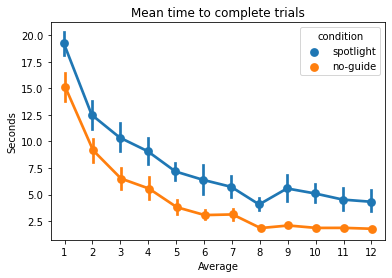

In [75]:
if not os.path.exists(f"./plots/{FOLDER_NAME}/trial_data/"):
    os.makedirs(f"./plots/{FOLDER_NAME}/trial_data/")

plt.figure()
sns.pointplot(data=trial_data, x='block_order', hue='condition', y=f'mean_ct', dodge=True, errorbar=('ci', 95)).set(title="Mean time to complete trials", xlabel="Average", ylabel="Seconds")
plt.savefig(f"./plots/{FOLDER_NAME}/trial_data/time_to_complete.png")

## Memory Test Analysis

In [76]:

spotlight_test_data_filtered = SPOTLIGHT_TRIAL_DATA[SPOTLIGHT_TRIAL_DATA['phase'] == 'testing']
spotlight_test_data_ordered = spotlight_test_data_filtered.sort_values(['participantID', 'timeSubmitted'])
spotlight_test_data_ordered['test_order'] = spotlight_test_data_ordered.groupby('participantID').cumcount() + 1
spotlight_test_data_ordered['condition'] = 'spotlight'


noguide_test_data_filtered = NOGUIDE_TRIAL_DATA[NOGUIDE_TRIAL_DATA['phase'] == 'testing']
noguide_test_data_ordered = noguide_test_data_filtered.sort_values(['participantID', 'timeSubmitted'])
noguide_test_data_ordered['test_order'] = noguide_test_data_ordered.groupby('participantID').cumcount() + 1
noguide_test_data_ordered['condition'] = 'no-guide'

test_data = pd.concat([spotlight_test_data_ordered, noguide_test_data_ordered], ignore_index=True)

In [77]:
ATTENTION_CHECK_IDS = [4, 8]

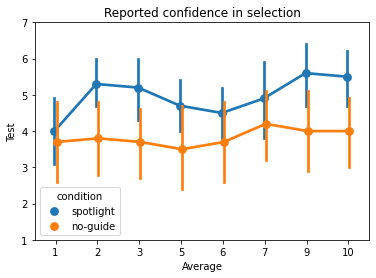

In [78]:
if not os.path.exists(f"./plots/{FOLDER_NAME}/test_data/"):
    os.makedirs(f"./plots/{FOLDER_NAME}/test_data/")

confidence = test_data[test_data['confidence']>0]

confidence = confidence[~confidence["test_order"].isin(ATTENTION_CHECK_IDS)]
# graph the mean engagement per trial order 
plt.figure()
sns.pointplot(data=confidence , x='test_order', hue='condition', y=f'confidence', dodge=True, errorbar=('ci', 95)).set(title="Reported confidence in selection", xlabel="Average", ylabel="Test")
plt.ylim(1, 7)
plt.savefig(f"./plots/{FOLDER_NAME}/test_data/confidence.png")


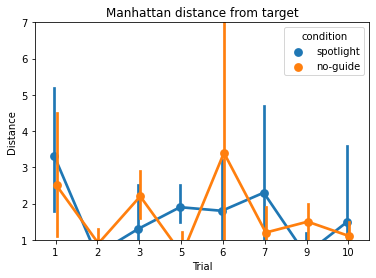

In [79]:
test_data = test_data[~test_data["test_order"].isin(ATTENTION_CHECK_IDS)]

plt.figure()
sns.pointplot(data=test_data, x='test_order', hue='condition', y=f'manhattan', dodge=True, errorbar=('ci', 95)).set(title="Manhattan distance from target", xlabel="Trial", ylabel="Distance")
plt.ylim(1, 7)
plt.savefig(f"./plots/{FOLDER_NAME}/test_data/manhattan_test_performance.png")